## Unsupervised Spectral Classification with PySpTools
This notebook runs through an example of spectral unmixing to carry out unsupervised classification of a SERC hyperspectral data file. 

In this tutorial, we use the following functions: 
- **`read_neon_reflh5`**: function to read in NEON AOP Hyperspectral Data file (in hdf5 format)
- **`clean_neon_refl_data`**: function to clean NEON hyperspectral data, including applying the data ignore value and reflectance scale factor, and removing water vapor bands
- **`RGBplot_widget`**: function to interactively plot different 3-band combinations of NEON hyperspectral data

We then use the **`PySpTools`** package to carry out endmember extraction, plot abundance maps of the spectral endmembers, and use Spectral Information Divergence to classify the SERC tile. 

https://pysptools.sourceforge.io/index.html

In [1]:
import os, h5py, time
import numpy as np
import pysptools.util as util
import pysptools.eea as eea #endmembers extraction algorithms
import pysptools.abundance_maps as amap
import pysptools.classification as cls
import pysptools.material_count as cnt

from skimage import exposure
from ipywidgets import *

%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

In [2]:
import matplotlib.pyplot as plt
import h5py, osr, copy

def read_neon_reflh5(refl_filename):
    """h5refl2array reads in a NEON AOP reflectance hdf5 file and returns 
    reflectance array, and header containing metadata in envi format.
    --------
    Parameters
        refl_filename -- full or relative path and name of reflectance hdf5 file
    --------
    Returns 
    --------
    reflArray:
        array of reflectance values
    header:
        dictionary containing the following metadata (all strings):
            bad_band_window1
            bad_band_window2
            bands: # of bands (float)
            coordinate system string: coordinate system information (string)
            data ignore value: value corresponding to no data (float)
            interleave: 'BSQ' (string)
            map info: ?
            reflectance scale factor: factor by which reflectance is scaled (float)
            wavelength: wavelength values (float)
            wavelength unit: 'm' (string)
                
            spatial extent meters: 
    --------
    This function applies to the NEON hdf5 format implemented in 2016, and should be used for
    data acquired during and after 2016 as of July 2018. Data in earlier NEON hdf5 format 
    (collected prior to 2016) is expected to be re-processed after the 2018 flight season. 
    --------
    Example Execution:
    --------
    sercRefl, sercRefl_header = h5refl2array('NEON_D02_SERC_DP1_20160807_160559_reflectance.h5') """
    
    #Read in reflectance hdf5 file (include full or relative path if data is located in a different directory)
    hdf5_file = h5py.File(refl_filename,'r')

    #Get the site name
    file_attrs_string = str(list(hdf5_file.items()))
    file_attrs_string_split = file_attrs_string.split("'")
    sitename = file_attrs_string_split[1]
    
    #Extract the reflectance & wavelength datasets
    refl = hdf5_file[sitename]['Reflectance']
    reflData = refl['Reflectance_Data']
    reflArray = refl['Reflectance_Data'].value
    
    #Create dictionary containing relevant metadata information
    header = {}
    header['map info'] = refl['Metadata']['Coordinate_System']['Map_Info'].value
    header['wavelength'] = refl['Metadata']['Spectral_Data']['Wavelength'].value

    #Extract no data value & set no data value to NaN
    header['data ignore value'] = float(reflData.attrs['Data_Ignore_Value'])
    header['reflectance scale factor'] = float(reflData.attrs['Scale_Factor'])
    header['interleave'] = reflData.attrs['Interleave']
    
    #Extract spatial extent from attributes
    header['spatial extent'] = reflData.attrs['Spatial_Extent_meters']
    
    #Extract bad band windows
    header['bad band window1'] = (refl.attrs['Band_Window_1_Nanometers'])
    header['bad band window2'] = (refl.attrs['Band_Window_2_Nanometers'])
    
    #Extract projection information
    header['projection'] = refl['Metadata']['Coordinate_System']['Proj4'].value
    header['epsg'] = int(refl['Metadata']['Coordinate_System']['EPSG Code'].value)
    
    #Extract map information: spatial extent & resolution (pixel size)
    mapInfo = refl['Metadata']['Coordinate_System']['Map_Info'].value
    
    hdf5_file.close        
    
    return reflArray, header

In [3]:
help(read_neon_reflh5)

Help on function read_neon_reflh5 in module __main__:

read_neon_reflh5(refl_filename)
    h5refl2array reads in a NEON AOP reflectance hdf5 file and returns 
    reflectance array, and header containing metadata in envi format.
    --------
    Parameters
        refl_filename -- full or relative path and name of reflectance hdf5 file
    --------
    Returns 
    --------
    reflArray:
        array of reflectance values
    header:
        dictionary containing the following metadata (all strings):
            bad_band_window1
            bad_band_window2
            bands: # of bands (float)
            coordinate system string: coordinate system information (string)
            data ignore value: value corresponding to no data (float)
            interleave: 'BSQ' (string)
            map info: ?
            reflectance scale factor: factor by which reflectance is scaled (float)
            wavelength: wavelength values (float)
            wavelength unit: 'm' (string)
          

In [4]:
load_start_time = time.time()
data_path = os.getcwd()
#header_file = 'NEON_D02_SERC_DP3_368000_4306000_reflectance.hdr'
#data_file = os.path.join(data_path,header_file)
h5refl_filename = 'NEON_D02_SERC_DP3_368000_4306000_reflectance.h5'
print('h5 file name:',h5refl_filename)
data,header = read_neon_reflh5(h5refl_filename)
print('Data took ', round(time.time() - load_start_time,1), ' seconds to load.')

h5 file name: NEON_D02_SERC_DP3_368000_4306000_reflectance.h5
Data took  7.1  seconds to load.


In [5]:
#Display information stored in header
for key in sorted(header.keys()):
  print(key)

bad band window1
bad band window2
data ignore value
epsg
interleave
map info
projection
reflectance scale factor
spatial extent
wavelength


In [6]:
def clean_neon_refl_data(data,header):
    """Clean h5 reflectance data and header
    1. set data ignore value (-9999) to NaN
    2. apply reflectance scale factor (10000)
    3. remove bad bands (water vapor bands + last 10 bands): 
        Band_Window_1_Nanometers = 1340,1445
        Band_Window_2_Nanometers = 1790,1955
    4. mask reflectance data > 1.0 ?? ##TO DO ?
    """
    
    #reflSubCleaned = reflArray[clipIndex['yMin']:clipIndex['yMax'],clipIndex['xMin']:clipIndex['xMax'],:].astype(np.float)
    #reflSubCleaned[reflSubCleaned==int(reflArray_metadata['noDataVal'])]=np.nan
    #reflSubCleaned = reflSubCleaned/reflArray_metadata['scaleFactor']
    
    data_clean = copy.copy(data)
    header_clean = copy.copy(header)
    #set data ignore value (-9999) to NaN:
    ## data_clean[data_clean==header['data ignore value']]=np.nan ??? get message ValueError: cannot convert float NaN to integer
    if header['data ignore value'] in data:
        print('data ignore values exist in data')
    #apply reflectance scale factor (divide by 10000)
    data_clean = data_clean/header['reflectance scale factor']
    #remove bad bands 
    #1. determine indices corresponding to min/max center wavelength for each bad band window:
    bb1_ind0 = np.max(np.where((np.asarray(header['wavelength'])<float(header['bad band window1'][0]))))
    bb1_ind1 = np.min(np.where((np.asarray(header['wavelength'])>float(header['bad band window1'][1]))))

    bb2_ind0 = np.max(np.where((np.asarray(header['wavelength'])<float(header['bad band window2'][0]))))
    bb2_ind1 = np.min(np.where((np.asarray(header['wavelength'])>float(header['bad band window2'][1]))))

    bb3_ind0 = len(header['wavelength'])-10
    
    #define valid band ranges from indices:
    vb1 = list(range(0,bb1_ind0)); #TO DO - don't hard code bands in, fi
    vb2 = list(range(bb1_ind1,bb2_ind0))
    vb3 = list(range(bb2_ind1,bb3_ind0))
    data_clean = data_clean[:,:,vb1+vb2+vb3]
    
    valid_band_range = [i for j in (range(0,bb1_ind0), range(bb1_ind1,bb2_ind0), range(bb2_ind1,bb3_ind0)) for i in j]
    header_clean['wavelength'] = [header['wavelength'][i] for i in valid_band_range]
    
    #Display wavelengths corresponding to bands removed:
    #print('Wavelengths Removed:')
    #print(header['wavelength'][191],'-',header['wavelength'][212],'nm')
    #print(header['wavelength'][281],'-',header['wavelength'][314],'nm')
    #print(header['wavelength'][416],'-',header['wavelength'][425],'nm')

    print('Bad Band Windows (nm):')
    print(header['bad band window1'])
    print(header['bad band window2'])
    
    #Display wavelengths corresponding to bands kept:
    print('\nCenter Wavelengths of Bands Kept:')
    print(header['wavelength'][0],'-',header['wavelength'][bb1_ind0],'nm')
    print(header['wavelength'][bb1_ind1],'-',header['wavelength'][bb2_ind0],'nm')
    print(header['wavelength'][bb2_ind1],'-',header['wavelength'][bb3_ind0],'nm')
    
    #header_clean['wavelength'] = header
    
    return data_clean, header_clean

In [7]:
print('Raw Data Dimensions:\n',data.shape)
#remove bad bands
clean_start_time = time.time()
data_clean,header_clean = clean_neon_refl_data(data,header)
print('\nData took', round(time.time() - clean_start_time,1), 'seconds to clean.')
print('Cleaned Data Dimensions:',data_clean.shape)

Raw Data Dimensions:
 (1000, 1000, 426)
Bad Band Windows (nm):
[1340 1445]
[1790 1955]

Center Wavelengths of Bands Kept:
383.534 - 1335.04 nm
1445.21 - 1785.75 nm
1956.02 - 2466.82 nm

Data took 47.7 seconds to clean.
Cleaned Data Dimensions: (1000, 1000, 360)


In [8]:
array = data_clean;
wavelengths = header['wavelength']
xmin = header['spatial extent'][0]; 
xmax = header['spatial extent'][1]; 
ymin = header['spatial extent'][2]; 
ymax = header['spatial extent'][3]; 

def RGBplot_widget(R,G,B):
    
    #Pre-allocate array  size
    rgbArray = np.zeros((array.shape[0],array.shape[1],3), 'uint8')
    
    Rband = array[:,:,R-1].astype(np.float)  
    Gband = array[:,:,G-1].astype(np.float)
    Bband = array[:,:,B-1].astype(np.float)

    rgbArray[..., 0] = Rband*256
    rgbArray[..., 1] = Gband*256
    rgbArray[..., 2] = Bband*256
    
    # Apply Adaptive Histogram Equalization to Improve Contrast:
    img_nonan = np.ma.masked_invalid(rgbArray) #first mask the image 
    img_adapteq = exposure.equalize_adapthist(img_nonan, clip_limit=0.10)
    
    plot = plt.imshow(img_adapteq,extent=[xmin,xmax,ymin,ymax]); 
    plt.title('Bands: \nR:' + str(R) + ' (' + str(round(wavelengths[R-1])) +'nm)'
              + '\n G:' + str(G) + ' (' + str(round(wavelengths[G-1])) + 'nm)'
              + '\n B:' + str(B) + ' (' + str(round(wavelengths[B-1])) + 'nm)'); 
    ax = plt.gca(); ax.ticklabel_format(useOffset=False, style='plain') 
    rotatexlabels = plt.setp(ax.get_xticklabels(),rotation=90) 
    
interact(RGBplot_widget, R=(1,426,1), G=(1,426,1), B=(1,426,1))

interactive(children=(IntSlider(value=213, description='R', max=426, min=1), IntSlider(value=213, description='G', max=426, min=1), IntSlider(value=213, description='B', max=426, min=1), Output()), _dom_classes=('widget-interact',))

<function __main__.RGBplot_widget>

## Unsupervised Classification with Spectral Unmixing: 
### Endmember Extraction and Abundance Mapping

**Spectral Unmixing** allows pixels to be composed of fractions or abundances of each class. 

**Endmembers** can be thought of as the basis spectra of an image. Once these endmember spectra are determined, the image cube can be 'unmixed' into the fractional abundance of each material in each pixel (Winter, 1999).

**Spectral Angle Mapper (SAM):**

**Spectral Information Divergence (SID):**

In [9]:
#ee.display?
wavelength_float = [float(i) for i in header_clean['wavelength']]
ee_axes = {}
ee_axes['wavelength'] = wavelength_float
ee_axes['x']='Wavelength, nm'
ee_axes['y']='Reflectance'

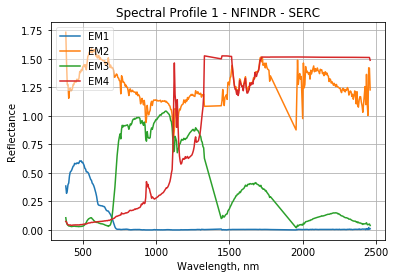

Endmember extraction took  96.6  seconds to run.


In [10]:
#Endmember Extraction (Unmixing) - NFINDR Algorithm (Winter, 1999)
ee_start_time = time.time()
ee = eea.NFINDR()
U = ee.extract(data_clean,4,maxit=5,normalize=False,ATGP_init=True)
ee.display(axes=ee_axes,suffix='SERC')
print('Endmember extraction took ', round(time.time() - ee_start_time,1), ' seconds to run.')

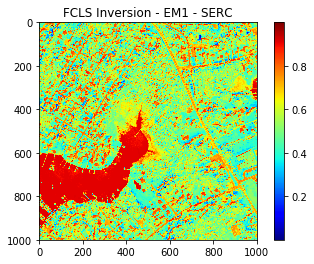

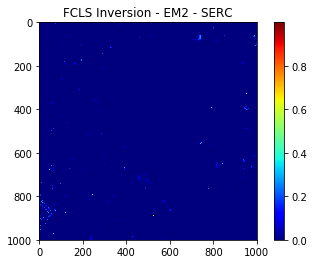

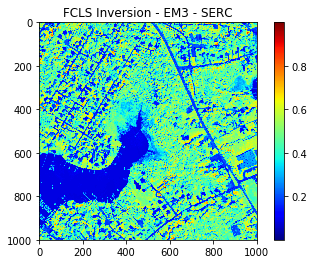

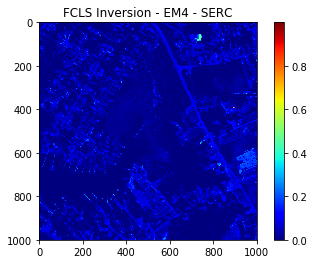

Abundance maps took  2495.1  seconds to generate.


In [11]:
#Abundance Maps
amap_start_time = time.time()
am = amap.FCLS()
amaps = am.map(data_clean,U,normalize=False)
am.display(colorMap='jet',columns=4,suffix='SERC')
print('Abundance maps took ', round(time.time() - amap_start_time,1), ' seconds to generate.')

Abundance Map Mean Values:
EM1: 0.591774
EM2: 0.00089542
EM3: 0.380964
EM4: 0.0263671


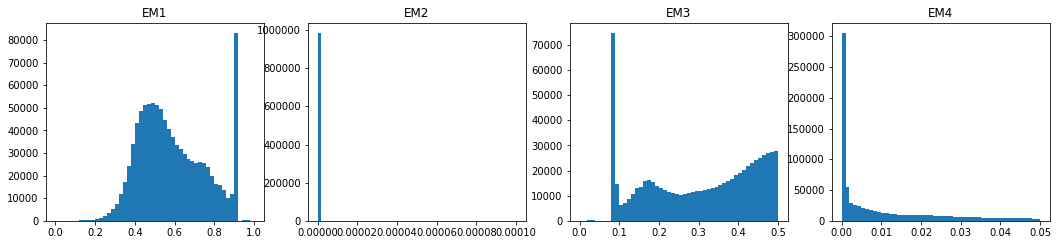

In [12]:
#Print mean values of each abundance map to better estimate thresholds
print('Abundance Map Mean Values:')
print('EM1:',np.mean(amaps[:,:,0]))
print('EM2:',np.mean(amaps[:,:,1]))
print('EM3:',np.mean(amaps[:,:,2]))
print('EM4:',np.mean(amaps[:,:,3]))

#Look at histogram of each abundance map to determine ballpark for thresholds to use
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(18,8))

ax1 = fig.add_subplot(2,4,1); plt.title('EM1')
amap1_hist = plt.hist(np.ndarray.flatten(amaps[:,:,0]),bins=50,range=[0,1.0]) 

ax2 = fig.add_subplot(2,4,2); plt.title('EM2')
amap1_hist = plt.hist(np.ndarray.flatten(amaps[:,:,1]),bins=50,range=[0,0.0001]) 

ax3 = fig.add_subplot(2,4,3); plt.title('EM3')
amap1_hist = plt.hist(np.ndarray.flatten(amaps[:,:,2]),bins=50,range=[0,0.5]) 

ax4 = fig.add_subplot(2,4,4); plt.title('EM4')
amap1_hist = plt.hist(np.ndarray.flatten(amaps[:,:,3]),bins=50,range=[0,0.05]) 

In [13]:
#Create functions to compute and display SAM and SID 

#Spectral Angle Mapper
def SAM(data,E,thrs=None):
    sam = cls.SAM()
    cmap = sam.classify(data,E,threshold=thrs)
    sam.display(colorMap='Paired',suffix='SERC')

#Spectral Information Divergence
def SID(data,E,thrs=None):
    sid = cls.SID()
    cmap = sid.classify(data,E,threshold=thrs)
    sid.display(colorMap='tab20b',suffix='SERC')

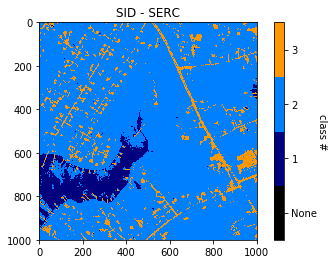

In [14]:
U2 = U[[0,2,3],:]
SID(data_clean, U2, [0.8,0.3,0.03])

Base Map


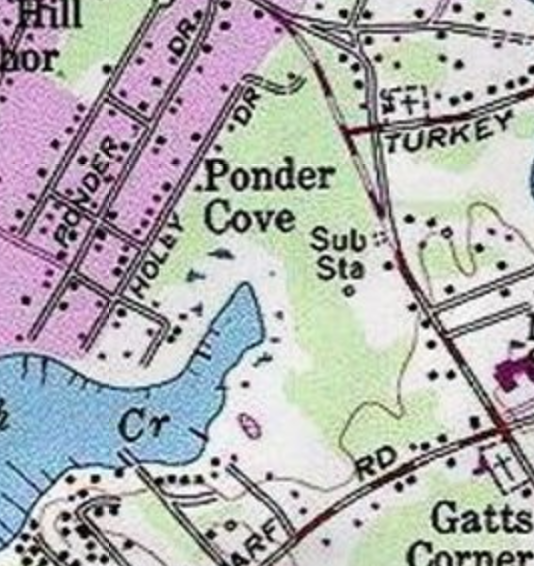

In [15]:
#Display USA Topo Base Map
#Reference: https://viewer.nationalmap.gov/
from IPython.core.display import Image
UStopo_filename = 'SERC_368000_4307000_UStopo.PNG'
UStopo_image = os.path.join(data_path,UStopo_filename)
print('Base Map')
Image(filename=UStopo_image,width=225,height=225)

## STOP HERE

In [ ]:
U3 = U[[0,2,3],:]
SID(data_clean, U3, [0.4,0.5,0.03])

#man_made = (amaps[:,:,1]>0.10)+(amaps[:,:,2]>0.10)+(amaps[:,:,3]>0.6)
#display(man_made)
#display((amaps[:,:,5]>0.1))
display((amaps[:,:,2]>0.035))
#display((amaps[:,:,2]>0.03)+(amaps[:,:,5]>0.05),'SERC Roads and Buildings')

In [ ]:
def plot_neon_refl(data,
                   header,
                   bands=(57,33,19),#if 1 band selected, default is __ (R), 
                                    #if 3 bands are selected, default bands are R,G,B ()
                   colorlimit=[0,1.0], #default colorlimit from 0 to 1
                   ax=plt.gca(),
                   title='',
                   cbar ='on',
                   cmap_title='',
                   colormap='spectral'):
    
    '''plot_band_array reads in and plots a single band of a reflectance array
    --------
    Parameters
    --------
        colorlimit: range of values to plot (min,max). Best to look at the histogram of reflectance values before plotting to determine colorlimit.
        ax: optional, default = current axis
        title: string, optional; plot title
        cmap_title: string, optional; colorbar title
        colormap: string, optional; see https://matplotlib.org/examples/color/colormaps_reference.html for list of colormaps
    --------
    Returns 
        plots flightline array of single band of reflectance data
    --------
    See Also
    --------
    Example:
    --------
    '''
    
    wavelengths = header['wavelength']
    xmin = header['spatial extent'][0]; 
    xmax = header['spatial extent'][1]; 
    ymin = header['spatial extent'][2]; 
    ymax = header['spatial extent'][3]; 
    refl_extent = [xmin,xmax,ymin,ymax]
    
#     if len(bands) == 1:
#         band_array = data[:,:,bands]
#         plot = plt.imshow(band_array,extent=refl_extent,clim=colorlimit); 
    if len(bands) == 3:
        rgbArray = np.zeros((data.shape[0],data.shape[1],3), 'uint8')
        Rband = data[:,:,bands[0]-1].astype(np.float)  
        Gband = data[:,:,bands[1]-1].astype(np.float)
        Bband = data[:,:,bands[2]-1].astype(np.float)
        rgbArray[..., 0] = np.log(Rband*256)
        rgbArray[..., 1] = np.log(Gband*256)
        rgbArray[..., 2] = np.log(Bband*256)
        
        # Apply Adaptive Histogram Equalization to Improve Contrast:
        img_nonan = np.ma.masked_invalid(rgbArray) #first mask the image 
        img_adapteq = exposure.equalize_adapthist(img_nonan, clip_limit=0.10)
    
        plot = plt.imshow(rgbArray,extent=refl_extent,clim=colorlimit); 
        plt.title('Bands: \nR:' + str(bands[0]) + ' (' + str(round(wavelengths[bands[0]-1])) +'nm)'
          + '\n G:' + str(bands[1]) + ' (' + str(round(wavelengths[bands[1]-1])) + 'nm)'
          + '\n B:' + str(bands[2]) + ' (' + str(round(wavelengths[bands[2]-1])) + 'nm)'); 
    if cbar == 'on':
        cbar = plt.colorbar(plot,aspect=40); plt.set_cmap(colormap); 
        cbar.set_label(cmap_title,rotation=90,labelpad=20)
    plt.title(title); ax = plt.gca(); 
    ax.ticklabel_format(useOffset=False, style='plain'); #do not use scientific notation #
    rotatexlabels = plt.setp(ax.get_xticklabels(),rotation=90); #rotate x tick labels 90 degrees

In [ ]:
plot_neon_refl(data,header,cbar='off')

In [ ]:
print(header['spatial extent'])

#Extract Spatial Extent (UTM xmin, xmax, ymin, ymax)
xmin = header['spatial extent'][0]; print('xmin:',xmin)
xmax = header['spatial extent'][1]; print('xmax:',xmax)
ymin = header['spatial extent'][2]; print('ymin:',ymin)
ymax = header['spatial extent'][3]; print('ymax:',ymax)

In [ ]:
def display(image,plot_title=''):
    import matplotlib.pyplot as plt
    img = plt.imshow(image,extent=[xmin,xmax,ymin,ymax])
    img.set_cmap('gray')
    ax=plt.gca()
    plt.setp(ax.get_xticklabels(),rotation=90); #rotate x tick labels 90 degrees
    plt.title(plot_title)
    plt.show()
    plt.clf()

In [ ]:
#Display linearly stretched RGB image of the SERC tile
#type(data_clean)
#util.display_linear_stretch(data_clean,58,34,19,suffix='SERC')
#wavelength_center_bands_valid
display(np.log(data_clean[:,:,34]))

In [ ]:
#print('EM5:',np.mean(amaps[:,:,4]))
#print('EM6:',np.mean(amaps[:,:,5]))
#print('EM7:',np.mean(amaps[:,:,6]))
#print('EM8:',np.mean(amaps[:,:,7]))
#print('EM9:',np.mean(amaps[:,:,8]))
#print('EM10:',np.mean(amaps[:,:,9]))

In [ ]:
ax5 = fig.add_subplot(2,4,5); plt.title('EM5')
amap1_hist = plt.hist(np.ndarray.flatten(amaps[:,:,4]),bins=50,range=[0,0.01]) 

ax6 = fig.add_subplot(2,4,6); plt.title('EM6')
amap1_hist = plt.hist(np.ndarray.flatten(amaps[:,:,5]),bins=50,range=[0,0.05]) 

ax7 = fig.add_subplot(2,4,7); plt.title('EM7')
amap1_hist = plt.hist(np.ndarray.flatten(amaps[:,:,6]),bins=50,range=[0,0.00001]) 

ax8 = fig.add_subplot(2,4,8); plt.title('EM8')
amap1_hist = plt.hist(np.ndarray.flatten(amaps[:,:,7]),bins=50,range=[0,0.0001]) 

## STOP HERE

If file is already in envi format (.dat, .hdr) you can use `pysptools.util.load_ENVI_file()`
```python
load_start_time = time.time()
data_path = os.getcwd()
header_file = 'NEON_D02_SERC_DP3_368000_4306000_reflectance.hdr'
data_file = os.path.join(data_path,header_file)
print('SERC Data Header:',data_file)
data,header = util.load_ENVI_file(data_file)
print('Data took ', time.time() - load_start_time, ' seconds to load.')```

In [ ]:
# U2 is a library made of 4 selected endmembers
SAM(data_clean, U2, [0.6,0.02,0.02,0.5])

In [ ]:
# Try another combination of 6 endmembers (adding 9)
U2 = U[[1,2,3,4,5,8],:]
SAM(data_clean, U2, [0.5,0.5,0.1,0.5,0.5,0.5])
SID(data_clean, U2, [0.5,0.5,0.05,0.5,0.3,0.5])

In [ ]:
U2 = U[[3,4,5,8],:]
SID(data_clean, U2, [0.1,0.5,0.5,0.5])

In [ ]:
# Try with just 3 endmembers
U2 = U[[3,4,5,8],:]
SAM(data_clean, U2, [0.5,0.1,0.5,0.5])

In [ ]:
##Package Installation (Can also install required packages from command line - activate py35 env first)
#https://stackoverflow.com/questions/45156080/installing-modules-to-anaconda-from-tar-gz
#import sys
#!{sys.executable} -m pip install spectral
#!{sys.executable} -m pip install scikit-image
#!conda install --yes --prefix {sys.prefix} h5py
#!{sys.executable} -m pip install "C:\Users\bhass\Downloads\pysptools-0.14.2.tar.gz
#!conda install --yes --prefix {sys.prefix} numpy
#!conda install --yes --prefix {sys.prefix} matplotlib
#!conda install --yes --prefix {sys.prefix} scikit-learn
#!conda install --yes --prefix {sys.prefix} cvxopt

#Look at histogram of each abundance map to determine ballpark for thresholds to use
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(18,8))

ax1 = fig.add_subplot(2,5,1); plt.title('EM1')
amap1_hist = plt.hist(np.ndarray.flatten(amaps[:,:,0]),bins=50,range=[0,0.25]) 

ax2 = fig.add_subplot(2,5,2); plt.title('EM2')
amap1_hist = plt.hist(np.ndarray.flatten(amaps[:,:,1]),bins=50,range=[0,0.1]) 

ax3 = fig.add_subplot(2,5,3); plt.title('EM3')
amap1_hist = plt.hist(np.ndarray.flatten(amaps[:,:,2]),bins=50,range=[0,0.02]) 

ax4 = fig.add_subplot(2,5,4); plt.title('EM4')
amap1_hist = plt.hist(np.ndarray.flatten(amaps[:,:,3]),bins=50,range=[0,1.0]) 

ax5 = fig.add_subplot(2,5,5); plt.title('EM5')
amap1_hist = plt.hist(np.ndarray.flatten(amaps[:,:,4]),bins=50,range=[0,0.001]) 

ax6 = fig.add_subplot(2,5,6); plt.title('EM6')
amap1_hist = plt.hist(np.ndarray.flatten(amaps[:,:,5]),bins=50,range=[0,0.001]) 

ax7 = fig.add_subplot(2,5,7); plt.title('EM7')
amap1_hist = plt.hist(np.ndarray.flatten(amaps[:,:,6]),bins=50,range=[0,1.0]) 

ax8 = fig.add_subplot(2,5,8); plt.title('EM8')
amap1_hist = plt.hist(np.ndarray.flatten(amaps[:,:,7]),bins=50,range=[0,0.0001]) 

ax9 = fig.add_subplot(2,5,9); plt.title('EM9')
amap1_hist = plt.hist(np.ndarray.flatten(amaps[:,:,8]),bins=50,range=[0,0.01]) 

ax10 = fig.add_subplot(2,5,10); plt.title('EM10')
amap1_hist = plt.hist(np.ndarray.flatten(amaps[:,:,9]),bins=50,range=[0,0.001]) 